In [0]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random as rnd

import seaborn as sns
from matplotlib import style
style.use('seaborn-pastel')

from keras.layers import Dense, Dropout, Flatten
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

from tqdm import tqdm_notebook

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, 
    IAAPiecewiseAffine, IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, ElasticTransform
)

import random
import pickle

Mounted at /content/gdrive


# **Data Mix**

---





In [0]:
cd '/content/gdrive/My Drive/Colab Notebooks/AML/mix'

/content/gdrive/My Drive/Colab Notebooks/AML/mix


In [0]:
imgs = []
labels = []
print("-- TOTAL LOAD --")
for lab in tqdm_notebook(os.listdir()):
  print("Load in {}".format(lab))
  for im in tqdm_notebook(os.listdir(lab)):
    imgs.append(cv.imread(os.path.join(lab, im)))
    labels.append(lab)

# imgs = np.array(imgs)
# labels = np.array(labels)

# imgs.shape, labels.shape

-- TOTAL LOAD --


Load in surprise


KeyboardInterrupt: ignored

In [0]:
# idx = np.random.permutation(len(imgs))
# labels = labels[idx]
# imgs = imgs[idx]

In [0]:
plt.figure(figsize = (15,5))
sns.countplot(labels)

In [0]:
plt.figure(figsize=(25, 8))
nimages = 10 
for i in range(nimages):
    ax = plt.subplot(2, nimages, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    l = random.randint(0, len(labels))
    plt.imshow(cv.cvtColor(imgs[l], cv.COLOR_BGR2RGB))
    plt.title(str(labels[l]))



```
# Prepare train and test
```



In [0]:
x_train, imgs_test, y_train, y_test = train_test_split(imgs, labels, test_size = .2, random_state = 42, stratify = labels)

# **Data mix + Family**

---



In [0]:
!unzip '/content/gdrive/My Drive/Colab Notebooks/AML/mix_and_family.zip'

In [0]:
cd '/content/mix_and_family'

In [0]:
imgs = []
labels = []
print("-- TOTAL LOAD --")
for lab in tqdm_notebook(os.listdir()):
  print("Load in {}".format(lab))
  for im in tqdm_notebook(os.listdir(lab)):
    imgs.append(cv.imread(os.path.join(lab, im)))
    labels.append(lab)

# imgs = np.array(imgs)
# labels = np.array(labels)

# imgs.shape, labels.shape

In [0]:
plt.figure(figsize = (15,5))
sns.countplot(labels)

In [0]:
plt.figure(figsize=(25, 8))
nimages = 10 
for i in range(nimages):
    ax = plt.subplot(2, nimages, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    l = random.randint(0, len(labels))
    plt.imshow(cv.cvtColor(imgs[l], cv.COLOR_BGR2RGB))
    plt.title(str(labels[l]))

In [0]:
x_train, imgs_test, y_train, y_test = train_test_split(imgs, labels, test_size = .2, random_state = 42, stratify = labels)

# **Data Full (ale + family + google)**

---



In [0]:
!unzip '/content/gdrive/My Drive/Colab Notebooks/AML/data_full.zip'

In [0]:
cd '/content/data_full'

/content/data_full


In [0]:
imgs = []
labels = []
print("-- TOTAL LOAD --")
for lab in tqdm_notebook(os.listdir()):
  print("Load in {}".format(lab))
  for im in tqdm_notebook(os.listdir(lab)):
    imgs.append(cv.imread(os.path.join(lab, im)))
    labels.append(lab)

-- TOTAL LOAD --


Load in neutral


Load in disgust


Load in sad


Load in angry


Load in happy


Load in surprise


Load in fear


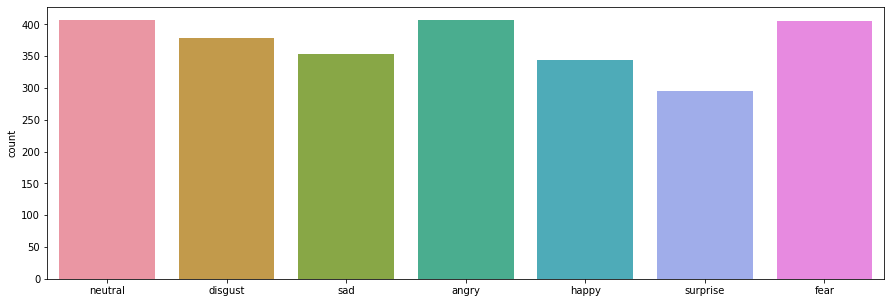

In [0]:
plt.figure(figsize = (15,5))
sns.countplot(labels)

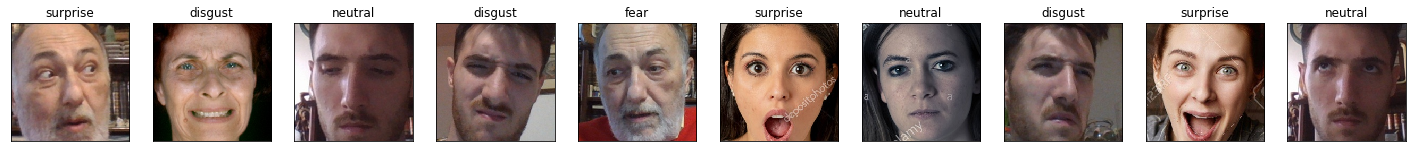

In [0]:
plt.figure(figsize=(25, 8))
nimages = 10 
for i in range(nimages):
    ax = plt.subplot(2, nimages, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    l = random.randint(0, len(labels))
    plt.imshow(cv.cvtColor(imgs[l], cv.COLOR_BGR2RGB))
    plt.title(str(labels[l]))

In [0]:
np.savez_compressed('/content/gdrive/My Drive/Colab Notebooks/AML/data.npz', imgs = imgs,
                    labels = labels)

In [0]:
x_train, imgs_test, y_train, y_test = train_test_split(imgs, labels, test_size = .2, random_state = 42, stratify = labels)

# Data Augmentation

In [0]:
def augment(aug, image):
    return aug(image=image)['image']

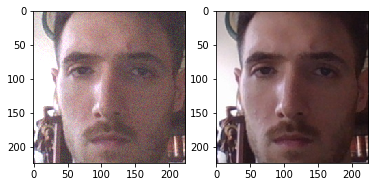

In [0]:
noise = GaussNoise(var_limit = (20,100), p = 1)
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(augment(noise, imgs[0]), cv.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(imgs[0], cv.COLOR_BGR2RGB))

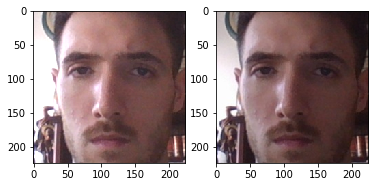

In [0]:
brightness = RandomBrightnessContrast(p=1, brightness_limit = 0.6, contrast_limit = 0.6)
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(augment(brightness, imgs[0]), cv.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(imgs[0], cv.COLOR_BGR2RGB))

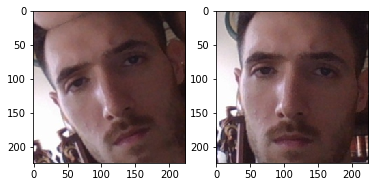

In [0]:
rotate = Rotate(p = 1, limit = (60))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(augment(rotate, imgs[0]), cv.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(imgs[0], cv.COLOR_BGR2RGB))

In [0]:
for i in tqdm_notebook(range(len(x_train))):
  prob = random.uniform(0, 1)
  if prob > 0.7:
    x_train.append(augment(noise, x_train[i]))
    y_train.append(y_train[i])
  prob = random.uniform(0, 1)
  if prob > 0.7:
    x_train.append(augment(brightness, x_train[i]))
    y_train.append(y_train[i])
  prob = random.uniform(0, 1)
  if prob > 0.7:
    x_train.append(augment(rotate, x_train[i]))
    y_train.append(y_train[i])

In [0]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(imgs_test)
y_test = np.array(y_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3997, 224, 224, 3), (3997,), (518, 224, 224, 3), (518,))

#**VggFace**

---




In [0]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-tcc21wm2
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-tcc21wm2
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=5a826917b4fee7553de89c962b305a059297c6d574d1a0146cc99e02ebc4081e
  Stored in directory: /tmp/pip-ephem-wheel-cache-i2lojeun/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [0]:
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

In [0]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = to_categorical(y_train, num_classes = 7)
y_test = le.fit_transform(y_test)
y_test = to_categorical(y_test, num_classes = 7)

In [0]:
x_train = x_train.astype('float64')
x_test = x_test.astype('float64')
x_train = preprocess_input(x_train, version=2)
x_test = preprocess_input(x_test, version=2)

In [0]:
np.max(x_train), np.min(x_train), x_train.shape, np.max(x_test), np.min(x_test), x_test.shape

(163.5047,
 -131.0912,
 (3997, 224, 224, 3),
 163.5047,
 -131.0912,
 (518, 224, 224, 3))

In [0]:
# count = 1
# nlayer_stop = 180
# for layer in base_model.layers:
#   if count <= nlayer_stop:
#     count += 1
#     layer.trainable = False
#   else:
#     break

In [0]:
def create_base_model(name_layer_stop):
  base_model = VGGFace(include_top = False, input_shape = (224, 224, 3), model='senet50')

  for layer in base_model.layers:
    if layer.name == name_layer_stop:
      break
    else:
      layer.trainable = False
  
  return base_model

base_model = create_base_model(name_layer_stop = 'conv5_1_1x1_reduce')
base_model.summary()














104947712/104944616 [==============================] - 1s 0us/step
Model: "vggface_senet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____

In [0]:
def create_model(base_model):
  model = Sequential()
  model.add(base_model)
  model.add(Flatten())
  model.add(Dense(512, activation = 'relu'))#, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01)))
  model.add(Dropout(.5))
  model.add(Dense(256, activation = 'relu'))#, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01)))
  model.add(Dropout(.5))
  model.add(Dense(128, activation = 'relu'))#, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01)))
  model.add(Dropout(.5))
  model.add(Dense(7, activation = 'softmax'))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])
  return model

model = create_model(base_model)
model.summary()

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, min_delta=0.01)
# checkpoint
filepath = "/content/gdrive/My Drive/Colab Notebooks/AML/weights-senet50-test.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_senet50 (Model)      (None, 1, 1, 2048)        26092144  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

In [0]:
n_epochs = 50
batch_size = 1024
val_split = .25

history_vggface = model.fit(x_train, y_train, epochs = n_epochs, validation_split = val_split,
                            verbose = 1, batch_size = batch_size)#, callbacks = callbacks_list)

Train on 2955 samples, validate on 985 samples
Epoch 1/50


In [0]:
 def model_plot(history): 
  fig, axes = plt.subplots(1, 2, figsize = (25, 8))
  colors = ['coral', 'lightgreen']

  axes[0].plot(history['loss'], color = colors[0])
  axes[0].plot(history['val_loss'], color = colors[1])
  # axes[0].title('model loss')
  # axes[0].ylabel('loss')
  # axes[0].xlabel('epoch')
  axes[0].legend(['train', 'val'], loc='upper left')

  axes[1].plot(history['acc'], color = colors[0])
  axes[1].plot(history['val_acc'], color = colors[1])
  # axes[1].title('model accuracy')
  # axes[1].ylabel('accuracy')
  # axes[1].xlabel('epoch')
  axes[1].legend(['train', 'val'], loc='upper left')

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/AML/trainHistoryDict_test', 'wb') as file_pi:
  pickle.dump(history_vggface.history, file_pi)

In [0]:
history = pickle.load(open('/content/gdrive/My Drive/Colab Notebooks/AML/trainHistoryDict_test', "rb"))

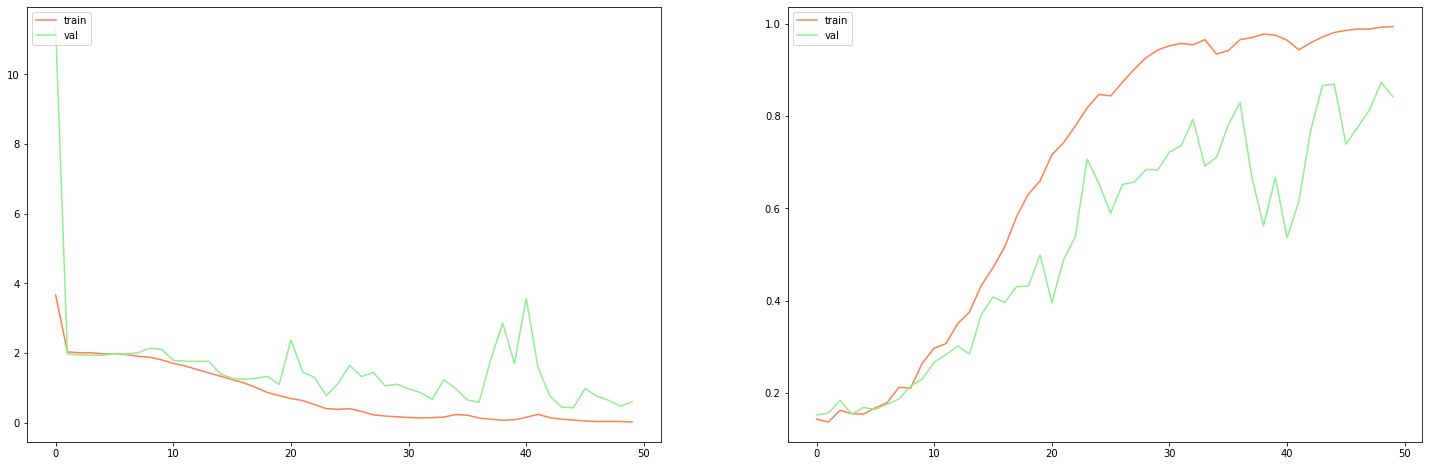

In [0]:
model_plot(history)

In [0]:
# load weights
model = load_model("/content/gdrive/My Drive/Colab Notebooks/AML/weights-senet50-full2.best.hdf5")

In [0]:
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]
loss = score[0]

print("Post-training accuracy: {} %".format(round(accuracy, 3)))
print("Post-training loss: {}".format(round(loss, 4)))

518/518 [==============================] - 4s 8ms/step
Post-training accuracy: 92.278 %
Post-training loss: 0.3657


In [0]:
y_true = np.argmax(y_test,axis=1)
y_pred = model.predict_classes(x_test)
print(classification_report(y_true, y_pred, target_names = le.inverse_transform([0,1,2,3,4,5,6])))

              precision    recall  f1-score   support

       angry       0.95      0.86      0.90        81
     disgust       0.91      0.92      0.92        76
        fear       0.88      0.89      0.88        81
       happy       0.97      1.00      0.99        69
     neutral       0.91      0.95      0.93        81
         sad       0.94      0.96      0.95        71
    surprise       0.91      0.88      0.90        59

    accuracy                           0.92       518
   macro avg       0.92      0.92      0.92       518
weighted avg       0.92      0.92      0.92       518



In [0]:
lab_test = le.inverse_transform(np.argmax(y_test, axis=1))
lab_pred = le.inverse_transform(y_pred)

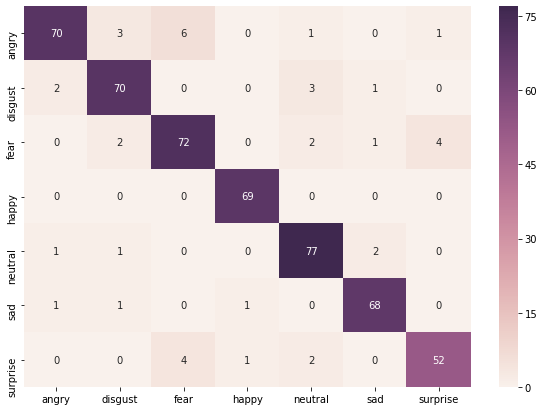

In [0]:
etichette = ['angry','disgust','fear','happy','neutral','sad','surprise']
cm = confusion_matrix(lab_test, lab_pred)
df_cm = pd.DataFrame(cm, index = etichette, columns = etichette)
plt.figure(figsize = (10,7))
cmap=sns.cubehelix_palette(1000, dark=0.2, light=0.95)
sns.heatmap(df_cm, annot=True, cmap=cmap)

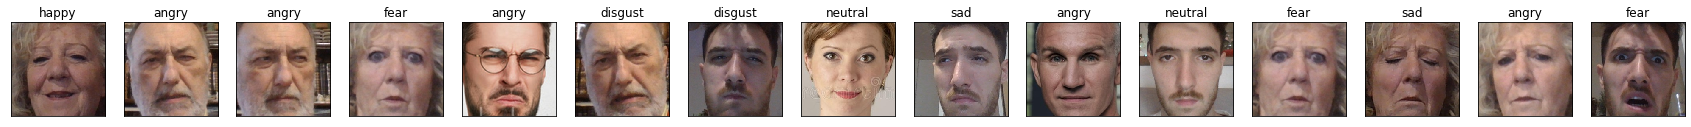

In [0]:
plt.figure(figsize=(30, 30))
nimages = 15 
for i in range(nimages):
    ax = plt.subplot(2, nimages, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    l = random.randint(0, len(lab_pred))
    plt.imshow(cv.cvtColor(imgs_test[l], cv.COLOR_BGR2RGB))
    plt.title(str(lab_pred[l]))

In [0]:
#save model and architecture to single file
#model.save("/content/gdrive/My Drive/Colab Notebooks/AML/vggface-senet50-model.h5")
print("Saved model to disk")

Saved model to disk
